In [1]:
# Use normalization for clustering, data must be normal
import numpy as np, pandas as pd, scipy, matplotlib.pyplot as plt, seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
%matplotlib inline

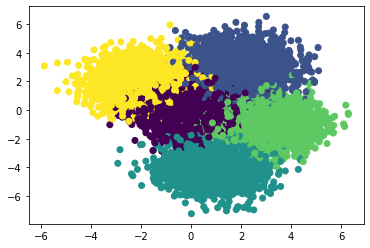

In [2]:
# Coordinates of centers of each blob
centers = [[0, 0], [2, 3], [1, -4], [3, -1], [-2, 2]]

# 10,000 samples with two features representing 3 clusters, stdev=1
X, y = make_blobs(
    n_samples=10000,
    centers=centers,
    cluster_std=1,
    n_features=2,
    random_state=42)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

# Split to train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.9, random_state=42)

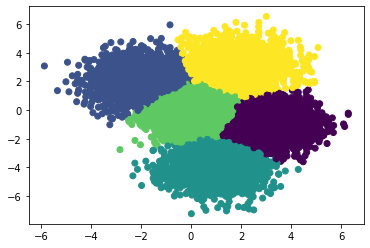

col_0     0     1     2     3     4
row_0                              
0        74    33    48  1590     0
1       128    23     0     0  1632
2        25     0  1727    66     0
3      1471    54    34   127   143
4        81  1687     0    30    27


In [9]:
# KMeans - Create predictions and plot solution
y_pred = KMeans(n_clusters=5, random_state=42).fit_predict(X_test)
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred)
plt.show()

# Check solution against data
print(pd.crosstab(y_pred,y_test))

In [4]:
# Mean Shift code
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set bandwidth automatically based on distances between datapoints
# Quantile controls bandwidth
bandwidth = estimate_bandwidth(X_train, quantile=0.144, n_samples=1500)

# Declare and fit model
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X_train)

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
cluster_centers = ms.cluster_centers_

# Count number of clusters
n_clusters_ = len(np.unique(labels))

print("number of estimated clusters: {}".format(n_clusters_))

number of estimated clusters: 5


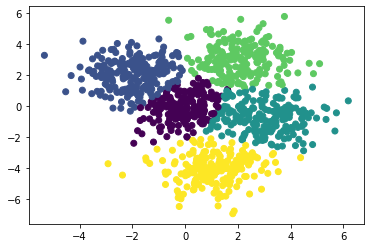

comparing the assigned categories to the ones in the data:
col_0    0    1    2    3    4
row_0                         
0      164   27   27    2    1
1        3    3    6  191    0
2        2    0    3    0  186
3        5    0  173    3    6
4        9  188    0    1    0


In [5]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=labels)
plt.show()

print("comparing the assigned categories to the ones in the data:")
print(pd.crosstab(y_train, labels))

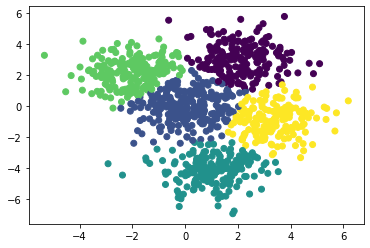

Comparing the assigned categories to the ones in the data:
col_0    0    1    2    3    4
row_0                         
0        1  202    0   11    7
1      188   10    0    3    2
2        0    5  181    0    5
3        2   18    4    0  163
4        1   17    0  180    0


In [10]:
from sklearn.cluster import SpectralClustering

# Declare and fit model, specify clusters
sc = SpectralClustering(n_clusters=5)
sc.fit(X_train)

# Predicted clusters
predict = sc.fit_predict(X_train)

# Graph results
plt.scatter(X_train[:, 0], X_train[:, 1], c=predict)
plt.show()

print("Comparing the assigned categories to the ones in the data:")
print(pd.crosstab(y_train,predict))

In [7]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# declare and fit model, model object takes arguements, none given
af = AffinityPropagation().fit(X_train)
print('Done')

# Pull number of clusters and assignments for each datapoint
cc_indices = af.cluster_centers_indices_
n_clusters_ = len(cc_indices)
labels = af.labels_

print("Estimated Number of Clusters: {}".format(n_clusters_))

Done
Estimated Number of Clusters: 29


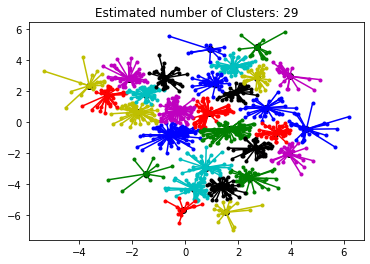

In [8]:
# Too many clusters
from itertools import cycle

plt.figure(1)
plt.clf()

# Cycle through each cluster and graph exemplar centerpoint and lines to each data point
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X_train[cc_indices[k]]
    plt.plot(X_train[class_members, 0], X_train[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in X_train[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of Clusters: {}".format(n_clusters_))
plt.show()

Report: 

After importing all the methods to a single document, the first thing I did was to add a fourth cluster to the blobs at coordinates of [-2, 2]. K-Means seems to perform roughly the same, drawing hard lines to form boundaries where the points overlap. Mean shift and spectral clustering easily catch the new blob as well. Affinity propagation, interestingly, finds less clusters (25) and more accurately assigns a group of points to each cluster, rather than having clusters with only a single point.

Second, I moved the cluster center at [2, -2] further away from the others to [4, -4]. All methods seemed to perform about the same. For K-Means, the clusters at [2, 2] and [-2, -2] seemed to absorb the more distant points of the new blob. Mean shift and spectral also performed similarly, trading off a single distant point between the clusters at [-2,-2] and [2, -2]. Affinity propagation again reduced the number of clusters (23) meaning that more points accepted a fewer number of exemplars to represent them.

Next, I moved the blobs to [-4, 4], [4, -4], [1, 1] and [-1, -1] to see how they would perform in finding clusters closer together. K-Means and spectral clustering were able to do so, which I suspect is a result of explicitly specificying the number of clusters each should look for (When I removed the kwarg from spectral, it found 8 clusters). Mean shift was only able to find 3 clusters with a bandwidth of 0.2, which makes sense as it would assume the data centered around [1, 1] and [-1, -1] was part of the same cluster. After playing with the bandwidth, however, it was able to correctly predict the number of clusters as low as 0.095 and as high as 0.144. Affinity propagation performed about the same.

Finally, I added clusters at random at [0, 0], [2, 3], [1, -4], [3, -1], and [-2, 2]. K-Means, mean shift, and spectral clustering all defined the clusters accurately, but K-Means appears to draw more defined lines between the clusters, where mean shift and spectral clustering seem to more accurately capture the relationship with the original data. Affinity propagation increased the number of clusters, but still clustered many points to each exemplar without creating single point clusters.